## The libraries

In this section, I load the libraries I use.

A short explanation for libs, I assume that are not that well known.

[`pandas`](https://pandas.pydata.org/): This lib helps to easily analyze and manipulate data <br>
[`seaborn`](https://seaborn.pydata.org/): This lib is for advanced data visualization and is based on [`matplotlib`](https://matplotlib.org/) <br>
[`scikit-learn`](https://scikit-learn.org/stable/index.html): Simple and efficient tool for all kinds of (traditional) ML tasks.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

## Loading the data

First, it is needed to load the data. For this purpose I use the pandas library.

Overall, I experiment with scaling the pulloff-row, to see if this has an positive effect. It could actually help,
because most labels are very low scale (1e-8) and therefore, it is hard to get a good metric.

In [2]:
data_file = '../../../data/RoughContact/pulloff4AIlabelled.csv'

column_names = ['Hurst', 'L', 'LambdaR', 'LambdaS', 'surfaceEnergy', 'rho', 'pulloff']

data = pd.read_csv(data_file)

# Hurst doesn't have any meaning at the moment, so it can be dropped
data.pop('Hurst')

# scaling pulloff Force
#data  = data.apply(lambda x: 1_000_000*x if x.name == 'pulloff' else x)

data

,L,lambdaR,lambdaS,surfaceEnergy,rho,pulloff
0,512,256,4,0.008652,0.037603,4.020000e-07
1,512,256,4,0.017304,0.059691,1.000000e-06
2,512,256,4,0.034609,0.094753,2.800000e-06
3,512,256,4,0.060566,0.137601,6.760000e-06
4,512,256,4,0.112480,0.207899,2.940000e-05
...,...,...,...,...,...,...
91,1024,128,2,0.951758,0.863281,2.372370e-02
92,1024,128,2,1.384375,1.108248,4.828920e-02
93,1024,128,2,1.990039,1.411591,8.272820e-02
94,1024,128,2,2.768750,1.759234,1.192725e-01


## Data Visualization

One of the most important things in machine learning is to know the data. One possible way is to use approbiate visualizations. 
With the knowledge we gain from visualizing the data, we can choose approbiate models.

So first I look at the correlations between the features. This is helpful, because we get a first idea about the relations in the data.
In this particular case, we see really strong correlations between the pulloff force, the surface energy and rho. The remaining features seem to 
be not that helpful. But that is natural, since the values of these columns don't vary very much. This is a first indication, that including the
features L, lambdaR and lambdaS won't help much.

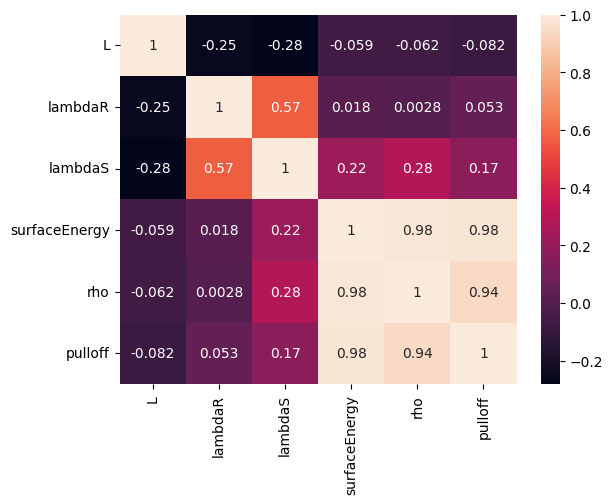

In [3]:
dataplot = sns.heatmap(data.corr(), cmap="rocket", annot=True)

plt.show()

### Pairplotting the relations

So now let's take a closer look at surfaceEnergy, rho and pulloff. What we 

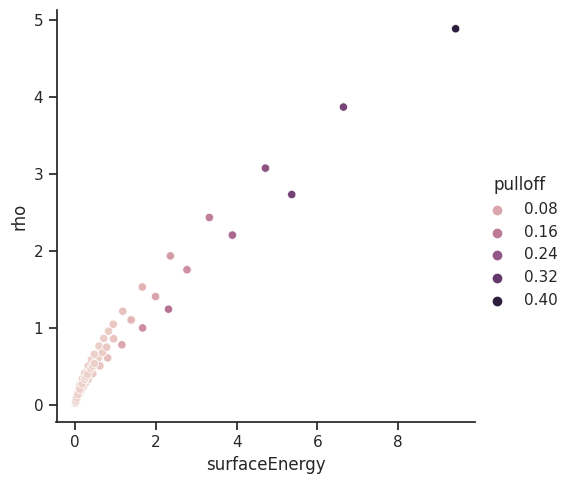

In [4]:
sns.set_theme(style="ticks")
sns.relplot(data[['surfaceEnergy', 'rho', 'pulloff']], x='surfaceEnergy', y='rho', hue='pulloff')

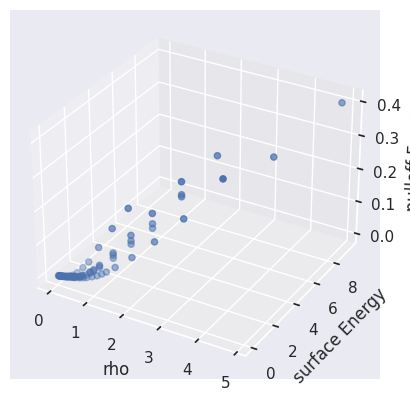

In [5]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = data['rho']
y = data['surfaceEnergy']
z = data['pulloff']

ax.set_xlabel("rho")
ax.set_ylabel("surface Energy")
ax.set_zlabel("pulloff Force")

ax.scatter(x, y, z)

plt.show()

<AxesSubplot: xlabel='pulloff', ylabel='Count'>

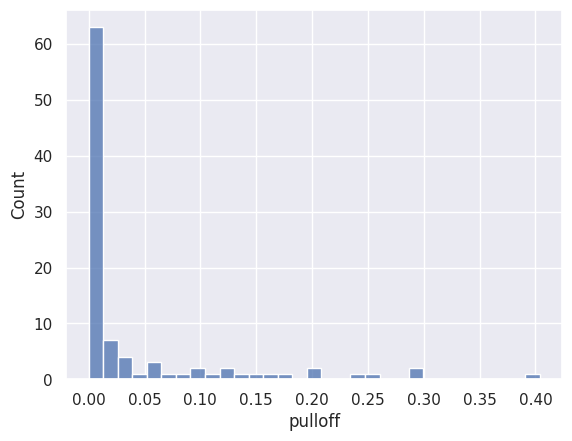

In [6]:
sns.histplot(data=data, x=data['pulloff'])

In [7]:
dataset = data.copy()

train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

X_train = train_dataset[['surfaceEnergy', 'rho']]
X_test = test_dataset[['surfaceEnergy', 'rho']]
Y_train = train_dataset['pulloff']
Y_test = test_dataset['pulloff']

In [8]:
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

LinearRegression()

In [9]:
preds = regr.predict(test_dataset[['rho', 'surfaceEnergy']])

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean squared error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], preds))

Coefficients: 
 [-0.0489557   0.07472524]
Mean squared error: 0.0002478735
Root Mean squared error: 0.0157440001
Mean squared error: 0.0098159534
Coefficient of determination: 0.94371


In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

pol_reg = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression(fit_intercept=False))
pol_reg.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

preds = pol_reg.predict(test_dataset[['rho', 'surfaceEnergy']])

# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['pulloff'], preds))

Mean squared error: 0.0001413279
Root Mean squared error: 0.0118881402
Mean absolute error: 0.0062176874
Coefficient of determination: 0.96791


In [13]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState()

ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=80), n_estimators=500, learning_rate=.5, random_state=rng
)

ada_regr.fit(train_dataset[['rho', 'surfaceEnergy']], train_dataset['pulloff'])

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=80),
                  learning_rate=0.5, n_estimators=500,
                  random_state=RandomState(MT19937) at 0x7F5C0674EA40)

In [14]:
preds = ada_regr.predict(test_dataset[['rho', 'surfaceEnergy']])

for y,y_ in zip(test_dataset['pulloff'], preds):
    print(y,y_)

print()
# the R2-score
print(r2_score(test_dataset['pulloff'], preds))
# The mean squared error
mse = mean_squared_error(test_dataset['pulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['pulloff'], preds))

0.00025142 0.0032090355
0.00349769 0.004238281
0.00514968 0.01233765
0.163872 0.12600364
0.00102244 0.00422735
0.00708614 0.0176362
0.0119421 0.0237237
0.0964343 0.13273478
0.253125 0.292737
2.27e-06 0.00288733
0.0228219 0.00963322
2.5e-06 0.00288733
2.36e-05 0.00288733
0.000144285 0.00422735
1.34e-07 0.00288733
2.07e-06 0.00288733
3.26e-05 0.0032090355
0.000333705 0.00422735
0.0090663 0.015883765

0.9408876808735086
Mean squared error: 0.0002603179
Root Mean squared error: 0.0161343706
Mean absolute error: 0.0103036291
